# **Gobest Cab – Sprint 2 (CA2): ML Model for Trip Safety Prediction**
**Role:** Person A (ML Engineer)  
**Goal:** Train a machine learning model to classify trips as **Safe (0)** or **Dangerous (1)** using sensor data.

**Deliverables for Sprint 2:**
1. ML-focused EDA
2. Advanced Feature Engineering (≥10 new features, no leakage)
3. Model training + evaluation (and later deployment integration)
4. Track experiments (e.g., MLflow)


---

`WHAT PREPROCESSING DOES:`
1. Data Quality Filtering (remove corrupted trips)
2. Column Removal (drop metadata, redundant columns)
3. Missing Value Handling (fill/verify NaNs)
4. Data Type Verification (ensure numeric, no inf)
5. Save cleaned data for feature engineering

`WHAT PREPROCESSING DOES NOT DO (comes later):`
- Scaling/Normalization → After feature engineering
- Train-test split → After feature engineering
- SMOTE/Class balancing → After feature engineering
- Feature selection → After feature engineering

---

### **Phase 1: Data Preprocessing (Next)**

- Filter trip durations: 120s ≤ duration ≤ 7,200s
- Remove trips with >80% sensor missingness
- Drop metadata columns (source_file, load_batch, etc.)
- Keep all quality/imputation flags (useful features)

In [43]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

print("="*70)
print("DATA PREPROCESSING - SPRINT 2")
print("="*70)
print(f"Start Time: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print()

DATA PREPROCESSING - SPRINT 2
Start Time: 2026-01-21 21:42:05



In [44]:
# Load the processed datasets
df = pd.read_pickle("datasets/df_sensor_merged_after_eda.pkl")
trip_features = pd.read_pickle("datasets/df_trip_features_after_eda.pkl")

print(df.shape, trip_features.shape)


(7206507, 46) (20000, 23)


In [45]:
print(f"Loaded sensor data:  {df.shape}")
print(f"Trips: {df['bookingID'].nunique()}")
print(f"Drivers: {df['driver_id'].nunique()}")
print(f"Date range: {df['second'].min()} to {df['second'].max()}")

# Quick verification
print("\nLabel distribution (trip-level):")
print(df.groupby('bookingID')['label'].first().value_counts())


Loaded sensor data:  (7206507, 46)
Trips: 20000
Drivers: 500
Date range: 0.0 to 619316528.0

Label distribution (trip-level):
label
0    15007
1     4993
Name: count, dtype: int64


In [46]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7206507 entries, 0 to 7206506
Data columns (total 46 columns):
 #   Column                   Dtype         
---  ------                   -----         
 0   bookingID                int64         
 1   Accuracy                 float64       
 2   Bearing                  float64       
 3   acceleration_x           float64       
 4   acceleration_y           float64       
 5   acceleration_z           float64       
 6   gyro_x                   float64       
 7   gyro_y                   float64       
 8   gyro_z                   float64       
 9   second                   float64       
 10  Speed                    float64       
 11  low_gps_quality_flag     bool          
 12  invalid_speed_flag       bool          
 13  extreme_speed_flag       bool          
 14  speed_imputed_flag       bool          
 15  bearing_missing_flag     bool          
 16  bearing_imputed_flag     bool          
 17  acc_x_missing_flag       bo

In [47]:
print(f"\nDataset shape: {df.shape}")
print(f"Total sensor readings: {df.shape[0]: ,}")
print(f"Total columns: {df.shape[1]}")
print(f"Unique trips (bookingID): {df['bookingID'].nunique():,}")
print(f"Unique drivers:  {df['driver_id'].nunique():,}")


Dataset shape: (7206507, 46)
Total sensor readings:  7,206,507
Total columns: 46
Unique trips (bookingID): 20,000
Unique drivers:  500


In [48]:
# Verify label distribution
trip_labels = df.groupby('bookingID')['label'].first()
print(f"\nLabel Distribution (trip-level):")
print(trip_labels.value_counts())
print(f"Danger rate: {trip_labels.mean()*100:.2f}%")


Label Distribution (trip-level):
label
0    15007
1     4993
Name: count, dtype: int64
Danger rate: 24.96%


---

**STEP 1: DATA QUALITY FILTERING**

Based on EDA findings, we identified critical data quality issues: 

1. TRIP DURATION ANOMALY: 
   - Safe trips: Mean = 165,903s (46 hours!)
   - Dangerous trips: Mean = 1,169s (19.5 minutes)
   - Some trips last 19 YEARS (sensor not turned off)
   
   `ISSUE`: Model would learn "long trip = safe" (spurious correlation)
   
   `SOLUTION`: Keep only trips between 120s (2 min) and 7,200s (2 hours)
   - Represents realistic trip durations
   - Removes sensor malfunction artifacts
   
2. SENSOR MISSINGNESS: 
   - Trips with >80% missing acceleration data are unreliable
   - Cannot extract meaningful driving behavior patterns

   SOLUTION: Remove trips with >80% acc_x missingness

**1.1 Trip Stats**

In [49]:
# First, calculate trip-level statistics for filtering
print("\nCalculating trip-level statistics...")

trip_stats = df.groupby('bookingID').agg({
    'second': lambda x: x.max() - x.min(),  # trip_duration
    'acc_x_missing_flag': 'mean',           # % missing acc_x
    'label': 'first'
}).reset_index()

trip_stats.columns = ['bookingID', 'trip_duration', 'acc_x_missing_pct', 'label']

print(f"Initial trips: {len(trip_stats):,}")


Calculating trip-level statistics...
Initial trips: 20,000


**1.2 Filter Trip duration**

In [50]:
# Filter 1: Trip duration 
print("Trip duration statistics (before filter):")
print(trip_stats['trip_duration'].describe())

# Define reasonable bounds
MIN_DURATION = 120    # 2 minutes (minimum meaningful trip)
MAX_DURATION = 7200   # 2 hours (maximum reasonable trip)

print(f"\nApplying filter: {MIN_DURATION}s ≤ duration ≤ {MAX_DURATION}s")
print(f"                 (2 minutes to 2 hours)")

# Identify trips to keep
valid_duration = trip_stats[
    (trip_stats['trip_duration'] >= MIN_DURATION) &
    (trip_stats['trip_duration'] <= MAX_DURATION)
]

print(f"\nTrips passing duration filter: {len(valid_duration):,}")
print(f"Trips removed: {len(trip_stats) - len(valid_duration):,}")
print(f"   ({(len(trip_stats) - len(valid_duration)) / len(trip_stats) * 100:.2f}% of total)")

Trip duration statistics (before filter):
count    2.000000e+04
mean     1.247775e+05
std      8.757779e+06
min      1.100000e+02
25%      5.530000e+02
50%      8.500000e+02
75%      1.214000e+03
max      6.193165e+08
Name: trip_duration, dtype: float64

Applying filter: 120s ≤ duration ≤ 7200s
                 (2 minutes to 2 hours)

Trips passing duration filter: 19,923
Trips removed: 77
   (0.39% of total)


In [51]:
# Check class distribution of removed trips
removed_duration = trip_stats[~trip_stats['bookingID'].isin(valid_duration['bookingID'])]
if len(removed_duration) > 0:
    print(f"\nRemoved trips by class:")
    print(removed_duration['label'].value_counts())
    print(f"   % Safe in removed:  {(removed_duration['label']==0).mean()*100:.2f}%")

trip_stats = valid_duration.copy()


Removed trips by class:
label
0    73
1     4
Name: count, dtype: int64
   % Safe in removed:  94.81%


**1.3 Sensor Missing acc. x**

In [52]:
# Filter 2: Sensor Missingness
print("\nAcceleration_X missingness statistics:")
print(trip_stats['acc_x_missing_pct'].describe())

MAX_MISSING_PCT = 0.80  # Allow up to 80% missing data

print(f"\nApplying filter: acc_x missing < {MAX_MISSING_PCT*100:.0f}%")

valid_sensors = trip_stats[trip_stats['acc_x_missing_pct'] < MAX_MISSING_PCT]

print(f"\nTrips passing sensor quality filter: {len(valid_sensors):,}")
print(f"Trips removed: {len(trip_stats) - len(valid_sensors):,}")
print(f"   ({(len(trip_stats) - len(valid_sensors)) / len(trip_stats) * 100:.2f}% of total)")

trip_stats = valid_sensors.copy()


Acceleration_X missingness statistics:
count    19923.000000
mean         0.026285
std          0.009969
min          0.000000
25%          0.019900
50%          0.025773
75%          0.031963
max          0.115385
Name: acc_x_missing_pct, dtype: float64

Applying filter: acc_x missing < 80%

Trips passing sensor quality filter: 19,923
Trips removed: 0
   (0.00% of total)


**1.4 Applying all filters that was done above**

In [53]:
# Apply filters to sensor-level data
valid_bookings = set(trip_stats['bookingID'])

df_filtered = df[df['bookingID'].isin(valid_bookings)].copy()

print(f"\nFILTERING RESULTS:")
print(f"   Original sensor readings: {len(df):,}")
print(f"   After filtering: {len(df_filtered):,}")
print(f"   Readings removed: {len(df) - len(df_filtered):,}")
print(f"   ({(len(df) - len(df_filtered)) / len(df) * 100:.2f}% of data)")

print(f"\n   Original trips: {df['bookingID'].nunique():,}")
print(f"   After filtering: {df_filtered['bookingID'].nunique():,}")
print(f"   Trips removed: {df['bookingID'].nunique() - df_filtered['bookingID'].nunique():,}")


FILTERING RESULTS:
   Original sensor readings: 7,206,507
   After filtering: 7,197,740
   Readings removed: 8,767
   (0.12% of data)

   Original trips: 20,000
   After filtering: 19,923
   Trips removed: 77


**1.5 Verifying class ditribytion after filtering**


Label counts:
label
0    14934
1     4989
Name: count, dtype: int64

Danger rate: 25.04%
Imbalance ratio (safe: dangerous): 2.99: 1


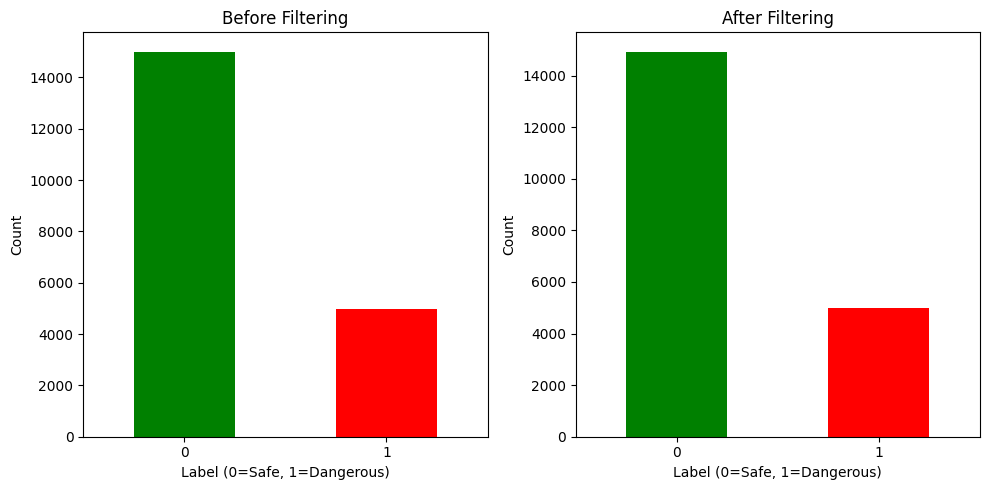

In [54]:
filtered_labels = df_filtered.groupby('bookingID')['label'].first()

print("\nLabel counts:")
print(filtered_labels.value_counts())
print(f"\nDanger rate: {filtered_labels.mean()*100:.2f}%")
print(f"Imbalance ratio (safe: dangerous): {(filtered_labels==0).sum() / (filtered_labels==1).sum():.2f}: 1")

# Visualize
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
trip_labels.value_counts().plot(kind='bar', color=['green', 'red'])
plt.title('Before Filtering')
plt.xlabel('Label (0=Safe, 1=Dangerous)')
plt.ylabel('Count')
plt.xticks(rotation=0)

plt.subplot(1, 2, 2)
filtered_labels.value_counts().plot(kind='bar', color=['green', 'red'])
plt.title('After Filtering')
plt.xlabel('Label (0=Safe, 1=Dangerous)')
plt.ylabel('Count')
plt.xticks(rotation=0)

plt.tight_layout()
plt.show()

---

**STEP 2: COLUMN REMOVAL**

`Remove non-feature columns:`

1. METADATA (not predictive):
   - source_file: File name (data pipeline artifact)
   - load_batch_id: ETL batch identifier
   - load_timestamp: When data was loaded
   
2. REDUNDANT COLUMNS: 
   - acceleration_x: Has NaNs; we have acceleration_x_filled (0-filled version)
   - date_of_birth: Already converted to 'age'
   
3. EDA-ONLY COLUMNS: 
   - proxy_risk_score:  Hand-crafted rule for leakage testing only
   - age_group:  Categorical bins created for EDA visualization

`COLUMNS TO KEEP: `
- Identifiers (for now): bookingID, driver_id (needed for feature engineering)
- Core sensors: Speed, Bearing, Accuracy, acceleration_y, acceleration_z, gyro_x/y/z
- Cleaned sensors: acceleration_x_filled (0-filled), longitudinal_acc
- Event flags: is_speeding, is_harsh_braking, is_harsh_acceleration, is_sharp_turn
- Quality flags: low_gps_quality_flag, acc_x_missing_flag, bearing_missing_flag, etc.
- Imputation flags: All *_imputed_flag columns
- Target:  label
- Driver features: age, driver_id
- Time:  second (for temporal computations)

In [55]:
print(f"Columns before removal: {df_filtered.shape[1]}")

# Define columns to drop
columns_to_drop = [
    # Metadata
    'source_file',
    'load_batch_id',
    'load_timestamp',
    
    # Redundant
    'acceleration_x',      # Keep acceleration_x_filled instead
    'date_of_birth',       # Already have 'age'
    
    # EDA-only
    'proxy_risk_score',    # Hand-crafted rule for leakage check
    'age_group',           # EDA visualization only
]

# Only drop columns that exist
cols_to_drop = [col for col in columns_to_drop if col in df_filtered.columns]

print(f"\nColumns to drop ({len(cols_to_drop)}):")
for col in cols_to_drop: 
    print(f"   - {col}")

# Drop columns
df_clean = df_filtered.drop(columns=cols_to_drop)

print(f"\nColumns after removal: {df_clean.shape[1]}")
print(f"   Dropped: {len(cols_to_drop)} columns")

Columns before removal: 46

Columns to drop (2):
   - acceleration_x
   - date_of_birth

Columns after removal: 44
   Dropped: 2 columns


In [65]:
df_clean.columns

Index(['bookingID', 'Accuracy', 'Bearing', 'acceleration_y', 'acceleration_z',
       'gyro_x', 'gyro_y', 'gyro_z', 'second', 'Speed', 'low_gps_quality_flag',
       'invalid_speed_flag', 'extreme_speed_flag', 'speed_imputed_flag',
       'bearing_missing_flag', 'bearing_imputed_flag', 'acc_x_missing_flag',
       'acceleration_x_filled', 'acc_y_missing_flag', 'acc_y_imputed_flag',
       'acc_z_missing_flag', 'acc_z_imputed_flag', 'gyro_x_missing_flag',
       'gyro_x_imputed_flag', 'gyro_y_missing_flag', 'gyro_y_imputed_flag',
       'gyro_z_missing_flag', 'gyro_z_imputed_flag', 'driver_id', 'label',
       'No_of_Years_driving_exp', 'gender', 'car_brand', 'car_model_year',
       'driver_rating', 'delta_speed', 'delta_time', 'longitudinal_acc',
       'is_speeding', 'is_harsh_braking', 'is_harsh_acceleration',
       'is_sharp_turn', 'age', 'is_stationary'],
      dtype='object')

In [66]:
# Display remaining columns by category
print("REMAINING COLUMNS (by category)")

all_cols = df_clean.columns.tolist()

# Categoridentifiers = [c for c in ['bookingID', 'driver_id', 'second'] if c in all_cols]
target = [c for c in ['label'] if c in all_cols]

core_sensors = [c for c in [
    'Speed','Bearing','Accuracy',
    'acceleration_x_filled','acceleration_y','acceleration_z',
    'gyro_x','gyro_y','gyro_z'
] if c in all_cols]

computed = [c for c in [
    'delta_speed','delta_time','longitudinal_acc'
] if c in all_cols]

event_flags = [c for c in [
    'is_speeding','is_harsh_braking','is_harsh_acceleration','is_sharp_turn','is_stationary'
] if c in all_cols]

# Treat ALL flags systematically
missing_flags = [c for c in all_cols if c.endswith('_missing_flag')]
imputation_flags = [c for c in all_cols if c.endswith('_imputed_flag')]
quality_flags = [c for c in all_cols if c in [
    'low_gps_quality_flag','invalid_speed_flag','extreme_speed_flag'
]]

# Driver features: include everything driver-related you actually have
driver_features = [c for c in [
    'age','No_of_Years_driving_exp','gender','car_brand','car_model_year','driver_rating'
] if c in all_cols]

# What’s left?
categorized = set(
    identifiers + target + core_sensors + computed + event_flags +
    missing_flags + imputation_flags + quality_flags + driver_features
)
uncategorized = [c for c in all_cols if c not in categorized]

print("\nIDENTIFIERS:", identifiers)
print("\nTARGET:", target)
print("\nCORE SENSORS:", core_sensors)
print("\nCOMPUTED:", computed)
print("\nEVENT FLAGS:", event_flags)
print("\nMISSING FLAGS:", missing_flags)
print("\nIMPUTATION FLAGS:", imputation_flags)
print("\nQUALITY FLAGS:", quality_flags)
print("\nDRIVER FEATURES:", driver_features)

if uncategorized:
    print("\nUNCATEGORIZED (review):", uncategorized)
else:
    print("\nAll columns were categorized.")

REMAINING COLUMNS (by category)

IDENTIFIERS: ['bookingID', 'driver_id', 'second']

TARGET: ['label']

CORE SENSORS: ['Speed', 'Bearing', 'Accuracy', 'acceleration_x_filled', 'acceleration_y', 'acceleration_z', 'gyro_x', 'gyro_y', 'gyro_z']

COMPUTED: ['delta_speed', 'delta_time', 'longitudinal_acc']

EVENT FLAGS: ['is_speeding', 'is_harsh_braking', 'is_harsh_acceleration', 'is_sharp_turn', 'is_stationary']

MISSING FLAGS: ['bearing_missing_flag', 'acc_x_missing_flag', 'acc_y_missing_flag', 'acc_z_missing_flag', 'gyro_x_missing_flag', 'gyro_y_missing_flag', 'gyro_z_missing_flag']

IMPUTATION FLAGS: ['speed_imputed_flag', 'bearing_imputed_flag', 'acc_y_imputed_flag', 'acc_z_imputed_flag', 'gyro_x_imputed_flag', 'gyro_y_imputed_flag', 'gyro_z_imputed_flag']

QUALITY FLAGS: ['low_gps_quality_flag', 'invalid_speed_flag', 'extreme_speed_flag']

DRIVER FEATURES: ['age', 'No_of_Years_driving_exp', 'gender', 'car_brand', 'car_model_year', 'driver_rating']

All columns were categorized.


---

**STEP 3: HANDLE REMAINING MISSING VALUES**

In [69]:
null_counts = df_clean.isnull().sum()
print(null_counts)

bookingID                      0
Accuracy                       0
Bearing                        0
acceleration_y                 0
acceleration_z                 0
gyro_x                         0
gyro_y                         0
gyro_z                         0
second                         0
Speed                          0
low_gps_quality_flag           0
invalid_speed_flag             0
extreme_speed_flag             0
speed_imputed_flag             0
bearing_missing_flag           0
bearing_imputed_flag           0
acc_x_missing_flag             0
acceleration_x_filled          0
acc_y_missing_flag             0
acc_y_imputed_flag             0
acc_z_missing_flag             0
acc_z_imputed_flag             0
gyro_x_missing_flag            0
gyro_x_imputed_flag            0
gyro_y_missing_flag            0
gyro_y_imputed_flag            0
gyro_z_missing_flag            0
gyro_z_imputed_flag            0
driver_id                      0
label                          0
No_of_Year

In [ ]:
# Check for NaNs
print("\nMissing values before handling:")
missing_cols = df_clean.isnull().sum()
missing_cols = missing_cols[missing_cols > 0].sort_values(ascending=False)

if len(missing_cols) > 0:
    print(missing_cols)
    print(f"\nTotal missing values:  {df_clean.isnull().sum().sum():,}")
else:
    print("   No missing values found!")


Missing values before handling:
delta_speed         19923
delta_time          19923
longitudinal_acc    19923
dtype: int64

Total missing values:  59,769


`Possible reason for missing values`

- All 3 columns needed a previous record to calculate its values

- First row might be NaN 

In [73]:
df_sorted = df_clean.sort_values(['bookingID', 'second']).copy()

# first row per trip
first_rows = df_sorted.groupby('bookingID').head(1)

# % of first rows that are NaN for each column
print(first_rows[['delta_speed','delta_time','longitudinal_acc']].isna().mean())


delta_speed         1.0
delta_time          1.0
longitudinal_acc    1.0
dtype: float64


In [74]:
rest_rows = df_sorted.groupby('bookingID').apply(lambda g: g.iloc[1:]).reset_index(drop=True)

print(rest_rows[['delta_speed','delta_time','longitudinal_acc']].isna().sum())


C:\Users\gohyu\AppData\Local\Temp\ipykernel_26340\313062173.py:1: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  rest_rows = df_sorted.groupby('bookingID').apply(lambda g: g.iloc[1:]).reset_index(drop=True)


delta_speed         0
delta_time          0
longitudinal_acc    0
dtype: int64


In [75]:
# handle missing values as needed
if len(missing_cols) > 0:
    print("\n" + "-"*70)
    print("FILLING MISSING VALUES")
    print("-"*70)
    
    # 1. Longitudinal acceleration (boundary effect)
    if 'longitudinal_acc' in df_clean.columns and df_clean['longitudinal_acc'].isnull().any():
        before = df_clean['longitudinal_acc'].isnull().sum()
        df_clean['longitudinal_acc'] = df_clean['longitudinal_acc'].fillna(0)
        print(f"\nlongitudinal_acc:  Filled {before:,} NaNs with 0 (trip boundaries)")
    
    # 2. Delta columns (boundary effect)
    for col in ['delta_speed', 'delta_time']:
        if col in df_clean.columns and df_clean[col].isnull().any():
            before = df_clean[col].isnull().sum()
            df_clean[col] = df_clean[col].fillna(0)
            print(f"{col}: Filled {before:,} NaNs with 0 (trip boundaries)")



----------------------------------------------------------------------
FILLING MISSING VALUES
----------------------------------------------------------------------

longitudinal_acc:  Filled 19,923 NaNs with 0 (trip boundaries)
delta_speed: Filled 19,923 NaNs with 0 (trip boundaries)
delta_time: Filled 19,923 NaNs with 0 (trip boundaries)


**Final Verification**

In [76]:
total_nans = df_clean.isnull().sum().sum()
print(f"\nTotal NaNs remaining: {total_nans}")

if total_nans == 0:
    print("   All missing values handled successfully!")
else:
    print("   WARNING: Some NaNs remain. Review required.")
    print(df_clean.isnull().sum()[df_clean.isnull().sum() > 0])


Total NaNs remaining: 0
   All missing values handled successfully!


---

**STEP 4: DATA TYPE & QUALITY VERIFICATION**

Ensure data is ready for feature engineering:

1. DATA TYPES:
   - All features must be numeric (int64 or float64)
   - Identifiers can be int64/object
   
2. INFINITE VALUES:
   - Check for np.inf or -np.inf
   - Can occur from division by zero
   - Strategy: Replace with NaN, then fill with 0
   
3. DATA RANGES:
   - Verify sensors are within expected ranges
   - Flag any suspicious values
   
4. SORTING:
   - Ensure data is sorted by (bookingID, second)
   - Critical for rolling window calculations

**4.1 Data types**

In [77]:
print("\nData type distribution:")
print(df_clean.dtypes.value_counts())

# Check for non-numeric columns (excluding identifiers)
non_numeric = df_clean.select_dtypes(exclude=[np.number]).columns.tolist()
non_numeric = [col for col in non_numeric if col not in ['bookingID', 'driver_id']]

if non_numeric:
    print(f"\nNon-numeric columns (excluding identifiers):")
    for col in non_numeric:
        print(f"   - {col}:  {df_clean[col].dtype}")
else:
    print("\nAll feature columns are numeric")


Data type distribution:
bool       17
float64    14
int64      10
object      2
int32       1
Name: count, dtype: int64

Non-numeric columns (excluding identifiers):
   - low_gps_quality_flag:  bool
   - invalid_speed_flag:  bool
   - extreme_speed_flag:  bool
   - speed_imputed_flag:  bool
   - bearing_missing_flag:  bool
   - bearing_imputed_flag:  bool
   - acc_x_missing_flag:  bool
   - acc_y_missing_flag:  bool
   - acc_y_imputed_flag:  bool
   - acc_z_missing_flag:  bool
   - acc_z_imputed_flag:  bool
   - gyro_x_missing_flag:  bool
   - gyro_x_imputed_flag:  bool
   - gyro_y_missing_flag:  bool
   - gyro_y_imputed_flag:  bool
   - gyro_z_missing_flag:  bool
   - gyro_z_imputed_flag:  bool
   - gender:  object
   - car_brand:  object


**4.2 Data Range verification**

In [81]:
# Check key sensors
key_sensors = {
    'Speed': (0, 60),  # 0 to 60 m/s (216 km/h max)
    'Bearing': (0, 360),  # 0 to 360 degrees
    'Accuracy': (0, 100),  # GPS accuracy in meters
    'acceleration_x_filled': (-20, 20),  # ±20 m/s²
    'acceleration_y': (-20, 20),
    'acceleration_z': (-20, 20),
    'gyro_x': (-10, 10),  # ±10 rad/s
    'gyro_y': (-10, 10),
    'gyro_z':  (-10, 10),
}

print("\nSensor range checks:")
warnings = []
for sensor, (min_val, max_val) in key_sensors.items():
    if sensor in df_clean.columns:
        actual_min = df_clean[sensor].min()
        actual_max = df_clean[sensor].max()
        
        out_of_range = (
            (df_clean[sensor] < min_val) | (df_clean[sensor] > max_val)
        ).sum()
        
        status = "✅" if out_of_range == 0 else "⚠️"
        print(f"   {status} {sensor}: [{actual_min:.2f}, {actual_max:.2f}] "
              f"(expected [{min_val}, {max_val}])")
        
        if out_of_range > 0:
            warnings.append(f"{sensor}: {out_of_range:,} values out of range")

if warnings:
    print(f"\nRange warnings:")
    for w in warnings: 
        print(f"   - {w}")
    print("\n   Note: These may be valid extreme values from Sprint 1 cleaning")
else:
    print("\nAll sensors within expected ranges")


Sensor range checks:
   ✅ Speed: [0.00, 50.00] (expected [0, 60])
   ✅ Bearing: [0.00, 360.00] (expected [0, 360])
   ✅ Accuracy: [0.75, 100.00] (expected [0, 100])
   ⚠️ acceleration_x_filled: [-38.98, 66.87] (expected [-20, 20])
   ⚠️ acceleration_y: [-57.80, 61.16] (expected [-20, 20])
   ⚠️ acceleration_z: [-78.45, 78.06] (expected [-20, 20])
   ⚠️ gyro_x: [-48.46, 30.71] (expected [-10, 10])
   ⚠️ gyro_y: [-55.16, 80.31] (expected [-10, 10])
   ⚠️ gyro_z: [-53.55, 45.06] (expected [-10, 10])

Range warnings:
   - acceleration_x_filled: 117 values out of range
   - acceleration_y: 7,253 values out of range
   - acceleration_z: 2,317 values out of range
   - gyro_x: 27 values out of range
   - gyro_y: 1,123 values out of range
   - gyro_z: 77 values out of range

   Note: These may be valid extreme values from Sprint 1 cleaning


`Why should we not do anything?`
- Above values, even though outside of 'normal' range, is acceptable

- They can happen due to:
    - Harsh events
    - Phone orientation issues
    - Sensor noise spikes


**4.3 Sorting Verification**

In [82]:
# Check if already sorted
is_sorted = (
    df_clean.groupby('bookingID')['second']
    .apply(lambda x: x.is_monotonic_increasing)
    .all()
)

if is_sorted:
    print("\nData already sorted by (bookingID, second)")
else:
    print("\nData not sorted. Sorting now...")
    df_clean = df_clean.sort_values(['bookingID', 'second']).reset_index(drop=True)
    print("Data sorted successfully")


Data already sorted by (bookingID, second)


---

**Final Stats**

In [83]:
print("\n" + "="*70)
print("PREPROCESSING SUMMARY")
print("="*70)

print(f"\nFINAL DATASET STATISTICS:")
print(f"   Rows (sensor readings): {df_clean.shape[0]: ,}")
print(f"   Columns: {df_clean.shape[1]}")
print(f"   Unique trips: {df_clean['bookingID'].nunique():,}")
print(f"   Unique drivers: {df_clean['driver_id'].nunique():,}")

print(f"\nDATA QUALITY:")
print(f"   Missing values: {df_clean.isnull().sum().sum()}")
print(f"   Infinite values: {sum([np.isinf(df_clean[col]).sum() for col in df_clean.select_dtypes(include=[np.number]).columns])}")
print(f"   Duplicates: {df_clean.duplicated(['bookingID', 'second']).sum()}")

print(f"\nLABEL DISTRIBUTION:")
trip_label_dist = df_clean.groupby('bookingID')['label'].first()
print(f"   Safe trips: {(trip_label_dist==0).sum():,} ({(trip_label_dist==0).mean()*100:.2f}%)")
print(f"   Dangerous trips: {(trip_label_dist==1).sum():,} ({(trip_label_dist==1).mean()*100:.2f}%)")


PREPROCESSING SUMMARY

FINAL DATASET STATISTICS:
   Rows (sensor readings):  7,197,740
   Columns: 44
   Unique trips: 19,923
   Unique drivers: 500

DATA QUALITY:
   Missing values: 0
   Infinite values: 0
   Duplicates: 0

LABEL DISTRIBUTION:
   Safe trips: 14,934 (74.96%)
   Dangerous trips: 4,989 (25.04%)


---

**Saving preprocessed data**

In [84]:
output_file = "datasets/sensor_data_preprocessed.pkl"
df_clean.to_pickle(output_file)


In [85]:
df_clean.columns

Index(['bookingID', 'Accuracy', 'Bearing', 'acceleration_y', 'acceleration_z',
       'gyro_x', 'gyro_y', 'gyro_z', 'second', 'Speed', 'low_gps_quality_flag',
       'invalid_speed_flag', 'extreme_speed_flag', 'speed_imputed_flag',
       'bearing_missing_flag', 'bearing_imputed_flag', 'acc_x_missing_flag',
       'acceleration_x_filled', 'acc_y_missing_flag', 'acc_y_imputed_flag',
       'acc_z_missing_flag', 'acc_z_imputed_flag', 'gyro_x_missing_flag',
       'gyro_x_imputed_flag', 'gyro_y_missing_flag', 'gyro_y_imputed_flag',
       'gyro_z_missing_flag', 'gyro_z_imputed_flag', 'driver_id', 'label',
       'No_of_Years_driving_exp', 'gender', 'car_brand', 'car_model_year',
       'driver_rating', 'delta_speed', 'delta_time', 'longitudinal_acc',
       'is_speeding', 'is_harsh_braking', 'is_harsh_acceleration',
       'is_sharp_turn', 'age', 'is_stationary'],
      dtype='object')